# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [4]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [5]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [6]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = 'outputs_0_preprocess_data'
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = 'outputs_2_optimize'
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [7]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 6291
Number of vocabulary: 7496
Maximum of seqlen: 38


## 1-2) Pretrained generators

In [8]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 44,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [9]:
my_generator_after = StackAugmentedVAE(**kwargs_generator)

In [10]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [11]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [12]:
from ReBADD_config import Reward_bcl2_bclxl_bclw as Reward

## 2-1) RL design

In [13]:
my_reward_ft = Reward(use_cuda=gpuconfigs.use_cuda, device=gpuconfigs.device)

[INFO] The pretrained encoders were succeessfully loaded
[INFO] The pretrained encoders were succeessfully loaded
[INFO] The pretrained encoders were succeessfully loaded
[DEBUG] BA(navitoclax,P10415) = 9.798
[DEBUG] BA(navitoclax,Q07817) = 7.514
[DEBUG] BA(navitoclax,Q92843) = 6.686


In [14]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft)

## 2-2) Training

In [15]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [16]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [17]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [18]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [19]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, filepath):
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "BA_A":ba_A_list,
                               "BA_B":ba_B_list,
                               "BA_C":ba_C_list,
                               "EXEC_TIME":execution_times})
    df_history.to_csv(filepath, index=False)
    return df_history

In [20]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 10
behavior_stepsize = 20

[0001] rl_loss: 1.125	reconst_loss: 1.038	entropy_loss: 0.088	reward: 0.642	tau: 0.303	(25.410 sec)
[0002] rl_loss: 1.347	reconst_loss: 1.247	entropy_loss: 0.099	reward: 0.758	tau: 0.308	(50.920 sec)
[0003] rl_loss: 0.843	reconst_loss: 0.730	entropy_loss: 0.113	reward: 0.510	tau: 0.308	(76.642 sec)
[0004] rl_loss: 1.853	reconst_loss: 1.724	entropy_loss: 0.129	reward: 0.950	tau: 0.314	(102.685 sec)
[0005] rl_loss: 1.159	reconst_loss: 1.017	entropy_loss: 0.142	reward: 0.758	tau: 0.314	(128.214 sec)
[0006] rl_loss: 0.749	reconst_loss: 0.592	entropy_loss: 0.157	reward: 0.570	tau: 0.314	(153.620 sec)
[0007] rl_loss: 1.056	reconst_loss: 0.886	entropy_loss: 0.170	reward: 0.607	tau: 0.314	(179.114 sec)
[0008] rl_loss: 0.783	reconst_loss: 0.602	entropy_loss: 0.181	reward: 0.502	tau: 0.314	(205.209 sec)
[0009] rl_loss: 1.152	reconst_loss: 0.963	entropy_loss: 0.189	reward: 0.633	tau: 0.314	(231.042 sec)
[0010] rl_loss: 0.961	reconst_loss: 0.745	entropy_loss: 0.216	reward: 0.647	tau: 0.314	(256.78

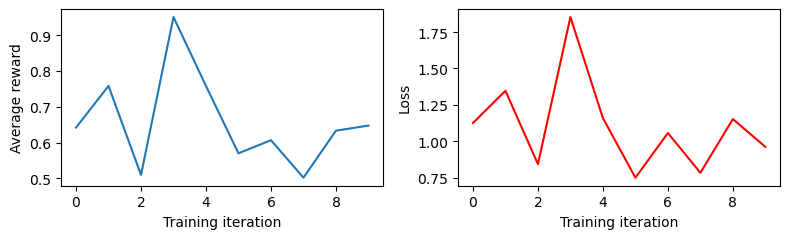

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.38it/s]


Sample trajectories: 100
[7.556, 8.571, 7.346, 0.751, 2.253, 1.098]    CCN(CC)S(=O)(=O)C1=CC=C(N2CCC(C(=O)N(C)CC3=CC=C(Cl)S3)CC2)C([N+1](=O)[O-1])=C1
[7.873, 7.703, 6.974, 1.134, 0.917, 0.667]    O=C(NCC(CO)CC1=CC(F)=CC(Br)=C1)C2CCC(N3C=C(C4=CC=C(N5CCC(O)CC5)C=C4)N=N3)C2
[6.331, 5.293, 5.832, 0.092, 0.012, 0.092]    O=C(NC(=O)C1CCCN1C(=O)C(N)CCCCNC(=O)OCC2=CC=CC=C2)C3=CC=CC=C3SC4=CC=C(S(=O)(=O)N5CCCC5)C=C4[N+1](=O)[O-1]
[5.848, 4.917, 4.694, 0.036, 0.006, 0.010]    CCCCCC(NC(=O)C1CCN(C2=CC=C(S(=O)(=O)N3CCOCC3)C4=C2[N+1](=O)[O-1])CC1)N=CNCCC(CO)NCC=C(C)C(O)CC(=O)N4
[5.986, 6.726, 5.630, 0.047, 0.193, 0.063]    CCN(CC)S(=O)(=O)C1=CC=C(OCC2OC(O)C(O)C(O)C2OC3OC(CO)C(O)C(O)C3O)C([N+1](=O)[O-1])=C1
[6.550, 6.113, 5.534, 0.139, 0.061, 0.052]    CC=CC(C12C(C(=O)OCC3=CC=CC=C3)C(=O)CC(C)(O)C1C(=O)OCC4=CC=CC=C4)=CC=C2Br
[6.623, 6.390, 5.926, 0.160, 0.103, 0.110]    CC=CC1=C(C2=CC=C(C(=O)N(C)CC=3C=CON=3)C(N4CCC(N5CCCC(CO)C5)CC4)=N2)C=C1
[7.309, 6.809, 5.971, 0.520, 0.224, 0.120]    COC1=CC=C(CN2CC

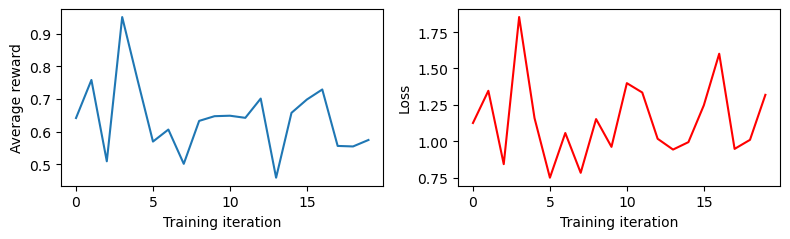

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.69it/s]


Sample trajectories: 100
[4.997, 5.151, 4.832, 0.007, 0.009, 0.013]    P1N=CN1C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)OP(=O)(O)OP(=O)(O)OCC3OC(N4C=NC=5C(=O)[NH1]C(N)=NC=54)C(O)C3O)C(O)C2OC=O
[6.189, 6.905, 5.953, 0.070, 0.266, 0.116]    COC1=CC=C(Br)C=2SC(NC(=O)C(C)NC(=O)C3=CC=4C(C)=NN(C)C=4S3)=NC1=2
[4.725, 4.070, 4.855, 0.004, 0.001, 0.014]    CC=CC#CCCC1=CC=CC=C1
[4.189, 3.753, 4.448, 0.001, 0.001, 0.006]    CC(NC(=O)C1CCN(C2=CC=C(S(=O)(=O)N3CCOCC3)C=C2[N+1](=O)[O-1])CC1)C4CC5CCC4C5
[3.869, 3.436, 4.561, 0.001, 0.000, 0.008]    C1OC=CC=CC=CC=C(CCC(F)(F)F)C=C1
[6.360, 6.040, 6.124, 0.097, 0.053, 0.160]    CCOC1=CC=C(NS(=O)(=O)C2=CC=C(NC(=O)CN(C3=CC=C(F)C(Cl)=C3)S(C)(=O)=O)C=C2)C=C1
[3.545, 3.274, 3.882, 0.000, 0.000, 0.002]    COC=CC=C(CC1=CC=C(Br)C=C1)COC
[5.817, 5.977, 5.174, 0.034, 0.046, 0.026]    CCN(CC)S(=O)(=O)C=1C=CC2=NN=C(SC(C)C(=O)NC3=CC=C(Cl)C=C3C(F)(F)F)N2C=1
[6.311, 5.358, 5.491, 0.089, 0.014, 0.048]    CC1=CC=C2C=C1OCCNC(=O)CC3CCC(CNC2=O)N3C(=O)C4=CC=C(C5=CC=CS5)C=C4
[5.639, 4

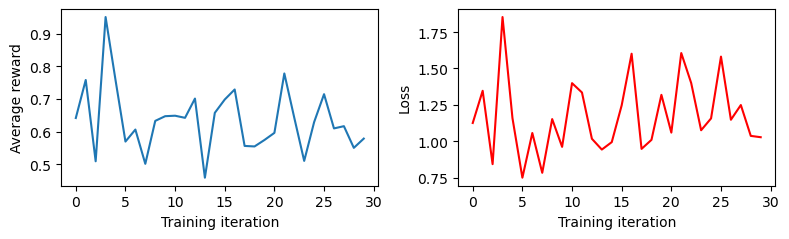

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.66it/s]


Sample trajectories: 100
[6.727, 6.660, 7.297, 0.193, 0.171, 1.033]    CS(=O)(NCC1=NN=C(SCC2C3CCO2)N1C4=CC=CC(C(F)(F)F)=C4)(C5=NN(S(=O)(=O)C6=CC=CC(F)=C6)C(C7=CC=C(C)C=C7)C5)CC=CN3
[6.952, 5.749, 5.514, 0.289, 0.030, 0.050]    COC1=CC=C2C=C1OCCN(S(=O)(=O)C3CCS(=O)(=O)C3)CCCCN(C(=O)CCC4=NC5=CC=CC=C5S4)CCCN6C=CN=C62
[5.608, 5.463, 6.773, 0.022, 0.017, 0.491]    O=C(C1=CN=C2C(=C1)C(O)=NC(=O)N2C3CC3)N4CCN(C5=CC=C(C(F)(F)F)C=C5[N+1](=O)[O-1])CC4
[5.953, 6.830, 6.167, 0.044, 0.232, 0.173]    COC1=CC=CC=C1OC2=CC=CC(OC)=C2CNC(=O)C(C(C)C)NC(=O)C3N(C(=O)CCC4=CC=NC=C4)CCCCNC(=O)C5=CC=C(OC)C(=C5)OC6=CC=C(C=C6F)CNC3=O
[5.929, 6.186, 6.313, 0.042, 0.070, 0.226]    O=C(C(=O)C1=CC=C2C(=C1)C3CC2)CCC(C4=CC=C(F)C=C4)CN3C(=O)C(CC5=CC=CC=C5)NC(=O)COC6=CC=C(C=C6)CCNC=O
[5.241, 5.623, 5.264, 0.011, 0.023, 0.031]    COC1=CC(OC)=C(CNC(=O)CCC(NC(=O)OCC2C3=CC=CC=C3C4=CC=CC=C42)C(=O)O)C(OC)=C1
[5.845, 6.004, 5.868, 0.036, 0.049, 0.099]    CCN(CC)S(=O)(=O)C1=CC=C(N2CCN(C(=O)CC34CC5CC(CC(O)(C5)C3)C4)CC2)C([N+1](=O)

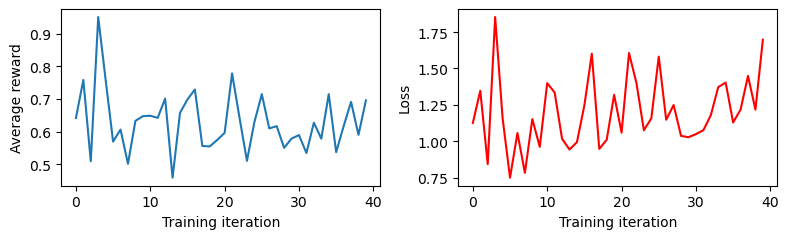

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.63it/s]


Sample trajectories: 100
[4.488, 4.498, 4.373, 0.002, 0.002, 0.005]    CCOC1=CC=C(S(=O)(=O)N2CCN(C(=O)C3=CC([N+1](=O)[O-1])=CC=C3N4CCOCC4)CC2)C=C1
[5.624, 5.452, 5.502, 0.023, 0.017, 0.049]    COC1=CC(O)=C2C(=O)C(OC3OC(CO)C(O)C(O)C3O)=C(C4=CC=C(OC5OC(CO)C(O)C(O)C5O)C=C4)OC2=C1
[5.599, 4.772, 4.614, 0.022, 0.004, 0.008]    O=C(CC=1C=C(Br)SC=1Br)NCC(NC(=O)C2=CC=CC(O)=N2)C3=CC=CC=C3
[4.548, 4.190, 4.229, 0.003, 0.001, 0.004]    C1OC(C(=O)OC2)CC(O)C(=O)C(C)C(OC3CC(C)(OC)C(O)C(C)O3)C(C)CC1C(NC(=O)OC(C)(C)C)C2O
[5.836, 5.978, 5.697, 0.035, 0.047, 0.071]    CC1=CC=C(C(=O)N2CCN(CC3=CN(C(C)C4=CC=C(C(F)(F)F)C=C4)N=N3)C(=O)C2)C=C1N5C(=O)C6CC=CCC6C5=O
[4.954, 5.581, 6.319, 0.006, 0.021, 0.228]    O=C(NC(=S)NC1=CC=C(N2CCN(C(=O)C3=CC=C(Cl)C=C3)CC2)C=C1)C=C4C=CCNC=CC=C=C4
[6.865, 5.948, 6.474, 0.248, 0.044, 0.299]    CCCN(CC(=O)NC1=CC=CC=C1C)C(=O)CSC2=NN=C(C3=CC=C(F)C=C3)N2CC4CCCO4
[5.598, 5.451, 5.428, 0.022, 0.016, 0.042]    C1OC=CC(OC)=COCC=CC=CC=C1Cl
[6.784, 6.118, 6.359, 0.214, 0.061, 0.245]    

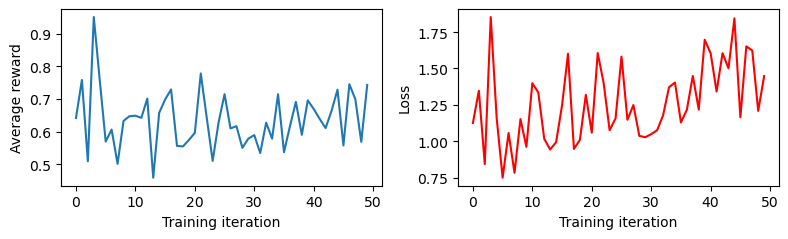

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 146.64it/s]


Sample trajectories: 100
[5.629, 4.449, 4.525, 0.023, 0.002, 0.007]    COC1=CC=C(S(=O)(=O)N2CCN(C(=O)CSCC3=NC(O)=C4C5=C(SC4=N3)CCCC5)CC2)C=C1[N+1](=O)[O-1]
[5.196, 5.090, 4.790, 0.010, 0.008, 0.012]    CC1=CC=C(S(=O)(=O)N(CC(=O)NC2=CC=C(S(=O)(=O)N3CCOCC3)C=C2)C4=CC=CC(Cl)=C4Cl)C=C1
[5.551, 5.988, 5.593, 0.020, 0.047, 0.058]    C1OC2=CC=C(C(OC)=C2OC)C=CC=C(CC=3C=NN(C4=CC=CC(Cl)=C4)C=3)C(=O)C=CC(NC(C)=O)CC1
[7.087, 6.001, 5.961, 0.363, 0.049, 0.118]    O=C(CN1CC(N2C=C(C(=O)OC)N=N2)CC1C(=O)NC(C3=CC=CC=C3)C4=CC=CC=C4)NC=CC=CCCC=NC=NCC=C
[5.933, 6.742, 5.567, 0.043, 0.199, 0.055]    CCOC1=CC2=CC(=C1)C(=O)N(C)CC(=O)NC3CN(C(=O)C=4C=NN(CC5=CC=CC=C5)C=4)CCC3OCC6=CC=CC(=C6)O2
[6.222, 5.491, 5.232, 0.075, 0.018, 0.029]    CC1=CC=C(F)C(C(=O)N2CCCCNC(=O)C(C)NC(=O)C(CC(C)C)NC(=O)C(CC3=CC=CC=C3)NC(=O)C4=CC=C(C=C4)C2)=C1F
[4.876, 3.760, 4.213, 0.005, 0.001, 0.004]    CC12CC3(O)OC(O1)C4(COC(=O)C5=CC=CC=C5)C3CC24OC6OC(COC(=O)C7=CC(O)=C(O)C(O)=C7)C(O)C(O)C6O
[4.035, 4.370, 4.370, 0.001, 0.002, 0.005]    

In [21]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

ba_A_list = []
ba_B_list = []
ba_C_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.1
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(n_batch=8, grad_clipping=1., alpha=alpha)
    
    ## append - reward
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_ba_A = 0.
    avg_ba_B = 0.
    avg_ba_C = 0.
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, ba_A, ba_B, ba_C, score_A, score_B, score_C = my_reward_ft(sm, debug=True)
                print(f"[{ba_A:.3f}, {ba_B:.3f}, {ba_C:.3f}, {score_A:.3f}, {score_B:.3f}, {score_C:.3f}]    {sm}")
                avg_ba_A += ba_A
                avg_ba_B += ba_B
                avg_ba_C += ba_C
            avg_ba_A /= len(smiles_cur)
            avg_ba_B /= len(smiles_cur)
            avg_ba_C /= len(smiles_cur)
    
    ## append - binding affinity values
    ba_A_list.append(avg_ba_A)
    ba_B_list.append(avg_ba_B)
    ba_C_list.append(avg_ba_C)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [22]:
ReBADD.generator.save_model(model_path)

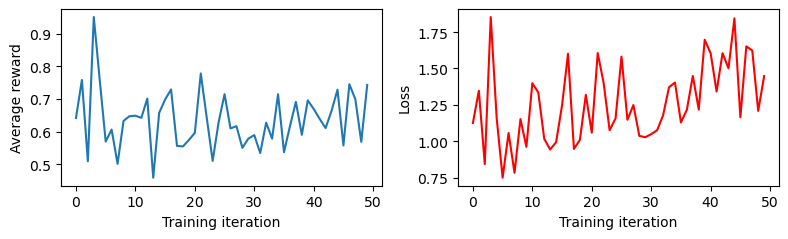

In [23]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [24]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(50, 8)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  BA_A  BA_B  BA_C  \
0  0.641867  1.125260      1.037565      0.087694   0.0   0.0   0.0   
1  0.758093  1.346581      1.247203      0.099378   0.0   0.0   0.0   
2  0.509699  0.842523      0.729620      0.112903   0.0   0.0   0.0   
3  0.950348  1.853291      1.724239      0.129052   0.0   0.0   0.0   
4  0.757883  1.158929      1.017129      0.141801   0.0   0.0   0.0   

    EXEC_TIME  
0   25.410235  
1   50.920327  
2   76.641877  
3  102.684894  
4  128.214163  


In [25]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [26]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [03:24<00:00, 146.49it/s]


In [27]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize/smi_after.csv
